In [1]:
# !pip install git+https://github.com/fastai/fastai2 
# !pip install git+https://github.com/fastai/fastcore

In [1]:
%matplotlib inline

In [2]:
from fastai2.vision.all import *
from nbdev.showdoc import *
set_seed(1)

In [3]:
from utils import *
from fastai2.vision.widgets import *

In [4]:
bs = 64

In [5]:
import os
os.listdir()

['Covid_Experiments.ipynb',
 'Covid_Production.ipynb',
 'Untitled.ipynb',
 'covid.jpeg',
 'Covid_Production.html',
 'Untitled.html',
 'data',
 'data.zip',
 'Untitled1.html',
 'Covid_Experiments.html',
 '.ipynb_checkpoints',
 'Untitled1.ipynb',
 '__MACOSX',
 'blood_cells']

In [6]:
#! unzip data.zip

In [7]:
path = Path('data')

In [8]:
path_img = path/'data/'

In [9]:
path.ls()

(#3) [Path('data/covid'),Path('data/normal'),Path('data/pneumonia')]

In [10]:
#path.ls()[0].unlink()

In [11]:
path.ls()

(#3) [Path('data/covid'),Path('data/normal'),Path('data/pneumonia')]

In [12]:
fnames = get_image_files(path)

In [13]:
fnames

(#956) [Path('data/covid/wong-0005.jpg'),Path('data/covid/fff49165-b22d-4bb4-b9d1-d5d62c52436c.annot.original.png'),Path('data/covid/446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg'),Path('data/covid/pneumocystis-pneumonia-2-L.png'),Path('data/covid/3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg'),Path('data/covid/ryct.2020200028.fig1a.jpeg'),Path('data/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg'),Path('data/covid/covid-19-pneumonia-22-day1-pa.png'),Path('data/covid/covid-19-pneumonia-bilateral.jpg'),Path('data/covid/44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg')...]

In [19]:
data = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.3,seed=2),
        get_y=parent_label,
        item_tfms=Resize(224)     
)

In [20]:
dls = data.dataloaders(path)

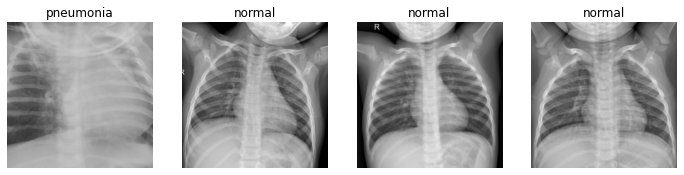

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

In [17]:
tfms = partial(aug_transforms, max_rotate=10, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [22]:
def get_dls(size, bs):
    covid = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2, seed=2),
                 get_y=parent_label,
                 item_tfms=RandomResizedCrop(400, min_scale=0.75),
                 batch_tfms=[*tfms(size=size,do_flip=False), Normalize.from_stats(*imagenet_stats)])
    return covid.dataloaders(path, path=path, bs=bs)

In [23]:
dls = get_dls(224,64)

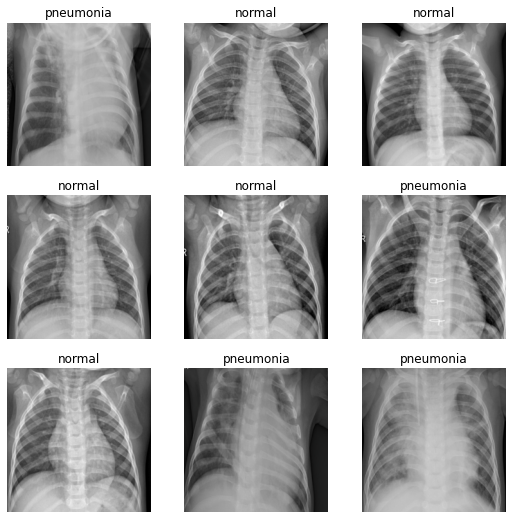

In [24]:
dls.valid.show_batch(max_n=9, nrows=3)

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.481249,1.383973,0.366492,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.549677,0.770690,0.272251,00:14
1,0.419305,0.409678,0.130890,00:14
2,0.355615,0.187622,0.041885,00:14
3,0.312927,0.219824,0.047120,00:15


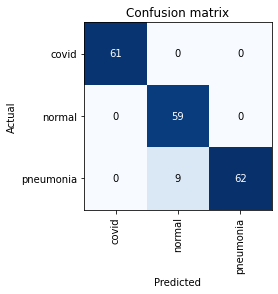

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [27]:
# learn.fine_tune(4)

In [28]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

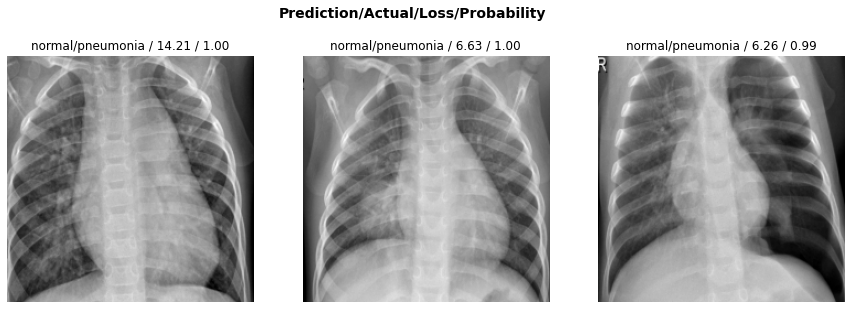

In [35]:
interp.plot_top_losses(3,nrows=1,figsize=(15,5))

In [36]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=7.585775847473997e-07)

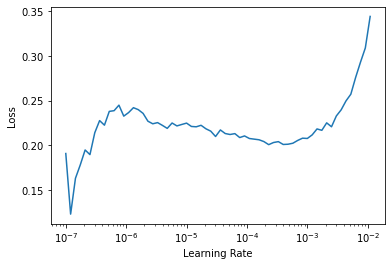

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.163507,0.229232,0.036649,00:14
1,0.196887,0.271420,0.036649,00:15
2,0.195378,0.198634,0.041885,00:15
3,0.190075,0.201389,0.026178,00:15
4,0.171067,0.237981,0.031414,00:14
5,0.168759,0.188887,0.015707,00:13
6,0.153896,0.143375,0.015707,00:14
7,0.147037,0.169176,0.015707,00:13
8,0.131743,0.164342,0.015707,00:13
9,0.118339,0.169921,0.015707,00:13


# Model Results

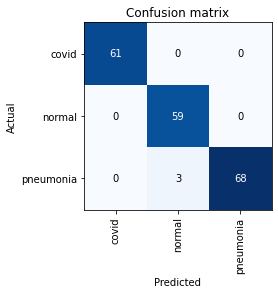

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

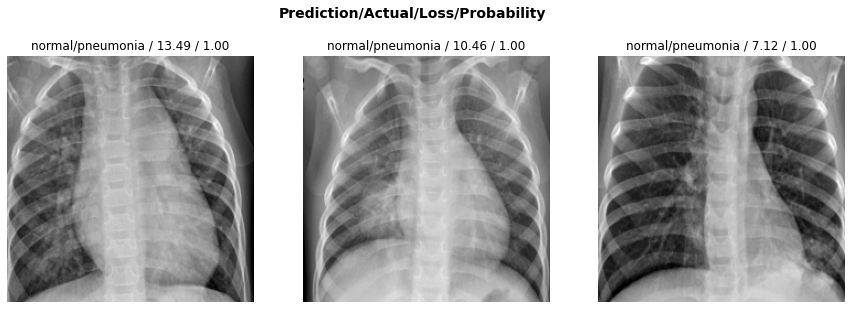

In [40]:
interp.plot_top_losses(3,nrows=1,figsize=(15,5))

In [44]:
interp.print_classification_report()

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        61
      normal       0.95      1.00      0.98        59
   pneumonia       1.00      0.96      0.98        71

    accuracy                           0.98       191
   macro avg       0.98      0.99      0.98       191
weighted avg       0.99      0.98      0.98       191



# Application

In [26]:
learn.export()

In [27]:
path = Path('data')
path.ls(file_exts='.pkl')

(#1) [Path('data/export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
path.ls()

(#4) [Path('data/pneumonia'),Path('data/normal'),Path('data/covid'),Path('data/export.pkl')]

In [30]:
learn_inf.predict('data/pneumonia/person72_bacteria_353.jpeg')

('pneumonia', tensor(2), tensor([3.4933e-04, 8.0628e-04, 9.9884e-01]))

In [31]:
learn_inf.dls.vocab

(#3) ['covid','normal','pneumonia']

# Notebook app

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['data/pneumonia/person72_bacteria_353.jpeg'])

In [31]:
img = PILImage.create(btn_upload.data[-1])

In [32]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(224,224))
out_pl


Output()

In [33]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: pneumonia; Probability: 0.9999')

In [35]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [37]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [38]:

HBox([widgets.Label('Please upload your X-ray'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [39]:

# #hide
# !pip install voila
# !jupyter serverextension enable voila --sys-prefix

# Heatmap

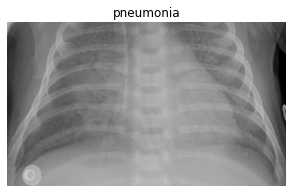

In [54]:

idx=50
x,y = dls.valid_ds[idx]
show_at(dls.valid_ds, idx);

In [55]:
m = learn.model.eval();

In [56]:

b = dls.one_batch()
xb_im = TensorImage(dls.train.decode(b)[0][0])
xb = b[0]

In [57]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [58]:

hook_a,hook_g = hooked_backward()

In [59]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [60]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [61]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ctx=ax)
    ax.imshow(hm, alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

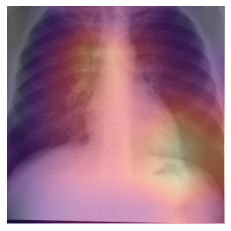

In [110]:
show_heatmap(avg_acts)

In [63]:
avg_acts

tensor([[0.3327, 0.6411, 1.0377, 0.9832, 0.8696, 0.5856, 0.4433],
        [0.3971, 0.9722, 1.5335, 1.4393, 1.1379, 0.7690, 0.5907],
        [0.4813, 1.0672, 1.4148, 1.3892, 1.0483, 0.9821, 0.8356],
        [0.5228, 1.0640, 1.2774, 1.3052, 1.2049, 1.4229, 1.2645],
        [0.6588, 0.9745, 1.1926, 1.3003, 1.4558, 1.8145, 1.5375],
        [0.7019, 1.0060, 1.2029, 1.2723, 1.4817, 1.7945, 1.4456],
        [0.5527, 0.8330, 0.9566, 0.9694, 1.0395, 1.3031, 1.0919]])

# Grad-CAM

In [64]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 7, 7]), torch.Size([512]))

In [65]:
mult = (acts*grad_chan[...,None,None]).mean(0)

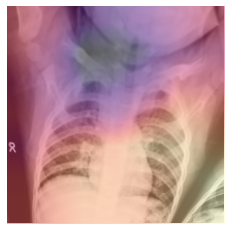

In [66]:
show_heatmap(mult)

In [67]:
fnames

(#956) [Path('data/pneumonia/person63_bacteria_306.jpeg'),Path('data/pneumonia/person26_bacteria_122.jpeg'),Path('data/pneumonia/person69_bacteria_338.jpeg'),Path('data/pneumonia/person60_bacteria_287.jpeg'),Path('data/pneumonia/person82_virus_154.jpeg'),Path('data/pneumonia/person53_bacteria_254.jpeg'),Path('data/pneumonia/person74_bacteria_362.jpeg'),Path('data/pneumonia/person55_bacteria_265.jpeg'),Path('data/pneumonia/person72_bacteria_353.jpeg'),Path('data/pneumonia/person64_bacteria_316.jpeg')...]

In [68]:
[c for c in fnames if 'covid' in str(c)]

[Path('data/covid/radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg'),
 Path('data/covid/9fdd3c3032296fd04d2cad5d9070d4_jumbo.jpeg'),
 Path('data/covid/radiol.2020201160.fig6b.jpeg'),
 Path('data/covid/covid-19-pneumonia-rapidly-progressive-3-days.jpg'),
 Path('data/covid/covid-19-pneumonia-23-day9.jpg'),
 Path('data/covid/pneumocystis-jirovecii-pneumonia-3-3.jpg'),
 Path('data/covid/covid-19-pneumonia-22-day2-pa.png'),
 Path('data/covid/radiol.2020201160.fig2c.jpeg'),
 Path('data/covid/396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg'),
 Path('data/covid/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg'),
 Path('data/covid/jkms-35-e79-g001-l-e.jpg'),
 Path('data/covid/jkms-35-e79-g001-l-d.jpg'),
 Path('data/covid/figure1-5e7c1b8d98c29ab001275405-98.jpeg'),
 Path('data/covid/pneumocystis-jirovecii-pneumonia-3-2.jpg'),
 Path('data/covid/da9e9aac-de8c-44c7-ba57-e7cc8e4caaba.annot.original.jpeg'),
 Path('data/covid/covid-19-pneumonia-58-prior.jpg'),
 Path('data/covid/31BA3780-2323-493F-8AED-620

In [71]:
'normal.jpg', 'covid_jpeg', 'pneumonia.jpeg'

('normal.jpg', 'covid_jpeg')

In [120]:
import os
[f for f in os.listdir() if 'jpeg' in f]

['covid.jpeg', 'pneumonia.jpeg']

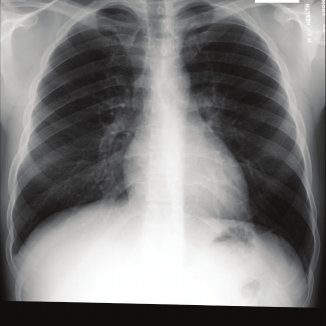

In [121]:
fn ='normal.jpg'
x = PILImage.create(fn);x

In [122]:
dl = dls.test_dl([fn])
b = dl.one_batch()
xb_im = TensorImage(dls.train.decode(b)[0][0])
xb = b[0]

In [123]:
hook_a,hook_g = hooked_backward()

In [124]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

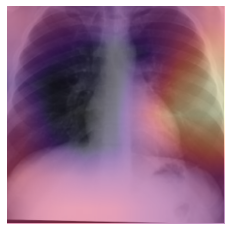

In [125]:
show_heatmap(mult)
